<a href="https://colab.research.google.com/github/allexanderprastya/PROJECT-TA-JURNAL/blob/main/IndoBERT_Base_16_Batch_LR2e_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq transformers

# Google Play App Sentiment Analysis 

### Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',font_scale=1.2)
sns.set_palette(sns.color_palette("rocket"))

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import transformers
from transformers import AutoModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Let's start by defining some key variables that will be used later on in the training/evaluation process
RANDOM_SEED = 42
BATCH_SIZE = 16 
# Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.
# Set seed for reproducibility.
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load the Dataset

In [4]:
df_reviews = pd.read_csv("/content/labelTextBlob_no_stem.csv")
df_reviews.head()

,content,label
0,bangkai turun knock langsung tolong tencent sa...,negative
1,mangapa pubg loading login kuota beli,neutral
2,bug developer perbaiki mengeluh bug lag,neutral
3,berat putar enak mainnya bagus,positive
4,game bagus sayang sinyal turun gameplay sulit ...,negative


In [5]:
# lets check the shape of reviews dataframe
df_reviews.shape

(14341, 2)

We have about 15k examples. Let's check for missing values-

In [6]:
df_reviews.isnull().sum()

content    0
label      0
dtype: int64

**Great, no missing values in the score and review texts! Do we have class imbalance?**

In [7]:
# helper function to draw percentage above each bar
def draw_percentage(ax,total=float(len(df_reviews))):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center',va='bottom')

**That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment.**

In [8]:
def to_sentiment(rating):
    if rating <= "negative":
        return 0
    elif rating == "neutral":
        return 1
    else:
        return 2
    
df_reviews['sentiment'] = df_reviews.label.apply(to_sentiment)

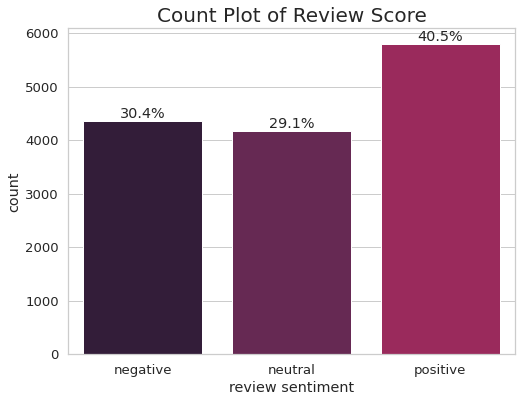

In [9]:
plt.figure(figsize = (8,6))
total = float(len(df_reviews))
ax = sns.countplot(x = 'sentiment',data=df_reviews)

class_names = ['negative', 'neutral', 'positive']
ax.set_xticklabels(class_names)
plt.title('Count Plot of Review Score', fontsize=20)
plt.xlabel('review sentiment')
draw_percentage(ax)

plt.show()

In [10]:
df_reviews

,content,label,sentiment
0,bangkai turun knock langsung tolong tencent sa...,negative,0
1,mangapa pubg loading login kuota beli,neutral,1
2,bug developer perbaiki mengeluh bug lag,neutral,1
3,berat putar enak mainnya bagus,positive,2
4,game bagus sayang sinyal turun gameplay sulit ...,negative,0
...,...,...,...
14336,game grafis buruk high definition keburikannya...,negative,0
14337,lambat,negative,0
14338,bagus banget,positive,2
14339,game seru keren high definition bug pemakaian ...,positive,2


### Data Preprocessing

In [11]:
# Saya menggunakan versi BERT tokenizer dari Indobenchmark (https://huggingface.co/indobenchmark/indobert-base-p1)
PRE_TRAINED_MODEL_NAME = 'indobenchmark/indobert-base-p2'

# Saya memuat BertTokenizer yang telah dilatih sebelumnya
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
sample_txt = "semenjak update game sinyalnya stabil download petanya saja lambat"

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: semenjak update game sinyalnya stabil download petanya saja lambat
   Tokens: ['semenjak', 'update', 'game', 'sinyal', '##nya', 'stabil', 'download', 'peta', '##nya', 'saja', 'lambat']
Token IDs: [9521, 4398, 2010, 5711, 57, 4860, 1974, 2577, 57, 377, 5163]


In [13]:
# pengkodean kalimat
encoding = tokenizer.encode_plus(
    sample_txt,
    padding='max_length', # Pad kalimat dengan panjang maksimum '[PAD]'.
    truncation=True,  #Potong kalimat menjadi panjang maksimum.
    max_length=32,
    add_special_tokens=True, # menambahkan '[CLS]' dan '[SEP]'
    return_token_type_ids=False,
    return_attention_mask=True, # Kembali attention mask
    return_tensors='pt',  # Kembali torch objects
    )

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

ID token sekarang disimpan di tensorflow tensor dan diisi dengan panjang 32.

In [14]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])

32
tensor([   2, 9521, 4398, 2010, 5711,   57, 4860, 1974, 2577,   57,  377, 5163,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


In [15]:
# Attention mask memiliki panjang yang sama
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])

32
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [16]:
#membalikkan tokenisasi untuk melihat token khusus
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'semenjak',
 'update',
 'game',
 'sinyal',
 '##nya',
 'stabil',
 'download',
 'peta',
 '##nya',
 'saja',
 'lambat',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Memilih Panjang Urutan

In [17]:
#Saya akan menggunakan strategi sederhana untuk memilih panjang maksimal yaitu simpan panjang token setiap review.
token_lens = []
for text in df_reviews.content:
    tokens = tokenizer.encode(text, truncation=True,max_length=512)
    token_lens.append(len(tokens))

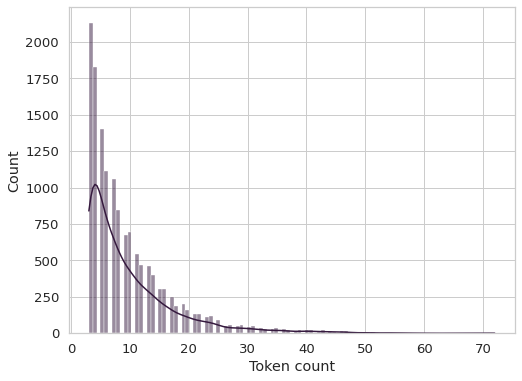

In [50]:
plt.figure(figsize = (8,6))
sns.histplot(token_lens,kde=True)
plt.xlabel('Token count')
plt.show()

Sebagian besar ulasan tampaknya berisi kurang dari 80 token, tetapi saya menggunakan panjang maksimum 100 untuk amannya.

In [19]:
MAX_LEN = 100

Sekarang setelah data telah diproses sebelumnya, saya dapat mengubahnya menjadi tensor PyTorch sehingga dapat meneruskannya ke model.

In [20]:
# We have all building blocks required to create a torch dataset.
class dataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        # langkah 1: dapatkan review dan target
        review = str(self.reviews[item])
        target = self.targets[item]
        # langkah 2: menggunakan tokenizer untuk mengkodekan kalimat (termasuk padding/cutting ke panjang maksimal)
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True, # menambahkan '[CLS]' dan '[SEP]'
            padding='max_length',  # Padding kalimat menjadi panjang maksimum.
            truncation=True,    # Potong kalimat menjadi panjang maksimum.
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True, # Kembali attention mask
            return_tensors='pt', # Kembali  torch objects/tensor
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(), # Tensor ID token untuk dimasukkan ke dalam model
            'attention_mask': encoding['attention_mask'].flatten(),  #Tensor Index yang menentukan token mana yang harus diperhatikan oleh model
            'targets': torch.tensor(target, dtype=torch.long)
            }

Tokenizer melakukan sebagian besar pekerjaan berat untuk model dan Saya mengembalikan teks ulasan, sehingga akan lebih mudah untuk mengevaluasi prediksi model.

In [21]:
#pisahkan data train, validation dan test (rasio 90:10:10)
df_train, df_test = train_test_split(df_reviews, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print('Train Data Size', df_train.shape)
print('Validation Data Size', df_val.shape)
print('Test Data Size', df_test.shape)

Train Data Size (12906, 3)
Validation Data Size (717, 3)
Test Data Size (718, 3)


Saya perlu membuat beberapa pemuat data. Inilah fungsi pembantu untuk model.

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = dataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
        ds,
        batch_size=batch_size
      )

Terapkan pemuat data untuk melatih data train, validation , dan test.

In [23]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

melihat kumpulan dari pemuat data training

In [24]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

### Bangun Model BERT

Saya akan menggunakan AutoModel untuk membangun pengklasifikasi sentimen dan muat modelnya

In [25]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Saya mencoba menggunakan bert_model pada pengkodean teks sampel.

In [26]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)
# The last_hidden_state adalah urutan status tersembunyi dari lapisan terakhir model.
# Mendapatkan pooled_output dilakukan dengan menerapkan BertPooler pada last_hidden_state.
last_hidden_state.shape

torch.Size([1, 32, 768])

Saya memiliki hidden_state untuk masing-masing dari 32 token (panjang urutan sampel) dan 768 adalah jumlah unit tersembunyi di jaringan feedforward. saya akan menggunakan torch.Size untuk membuat classifier model BERT.

In [27]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
        # dropout layer untuk beberapa regularisasi
        self.drop = nn.Dropout(p=0.3)
        # Lapisan yang sepenuhnya terhubung untuk output terakhir
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        """
        Masukkan input ke BERT dan classifier untuk menghitung logit.
        @param    input_ids(torch.Tensor): masukan tensor dengan bentuk (batch_size, 
                          max_length)
        @param    attention_mask (torch.Tensor): tensor yang memegang informasi attention mask dengan bentuk (batch_size, 
                          max_length)
        @return   logits (torch.Tensor): sebuah tensor keluaran dari formulir (batch_size, 
                          number_label)
        """
        # Masukkan input ke BERT
        last_hidden_state,pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [28]:
# Membuat instance dan pindahkan ke GPU.
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [29]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [30]:
# We'll move the example batch of our training data to the GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


### Model Training

In [31]:
EPOCHS = 5
#  AdamW optimizer to correct weight decay
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
#  We'll also use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# cross-entropy loss function
loss_fn = nn.CrossEntropyLoss().to(device)

Let's continue with writing a helper function for training our model...

In [32]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    # put model in training mode
    model = model.train()
    # Create empty lists to store outputs
    losses = []
    correct_predictions = 0
    for batch in data_loader:
        # We'll move the example batch of our training data to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        # Perform a forward pass. This will return logits.
        outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
        # Get the predictions
        _, preds = torch.max(outputs, dim=1)

        # Compute loss and accumulate the loss values
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # Calculate the accuracy rate
        correct_predictions += torch.sum(preds == targets)
        # backward pass - Perform a backward pass to calculate gradients
        loss.backward()
        # gradient clipping - Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Update parameters and the learning rate
        optimizer.step()
        scheduler.step()
        # Zero out any previously calculated gradients
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)  # Compute the average accuracy and loss over the training set.

Let's write another one that helps us evaluate the model on a given data loader.

In [33]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    # put model in evaluation mode
    model = model.eval()
    # Create empty lists to store outputs
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            # We'll move the example batch of our validation data to the GPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device) 

            # Perform a forward pass. This will return logits.
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            # Get the predictions
            _, preds = torch.max(outputs, dim=1) 

            # Compute loss and accumulate the loss values
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            # Calculate the accuracy rate
            correct_predictions += torch.sum(preds == targets)
            
    return correct_predictions.double() / n_examples, np.mean(losses) # Compute the average accuracy and loss over the validation set.

Using those two helper function, we can write our training loop. We'll also store the training history for future use...

In [34]:
%%time
history = defaultdict(list)
best_accuracy = 0
# Start training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 100)
    # model training
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    # After the completion of each training epoch, measure the model's performance on our validation set.
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss   {val_loss} accuracy {val_acc}')
    print()
    # append training accuracy,loss and validation accuracy and loss to the history variable
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model based on below condition
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------------------------------------------------------------------------------------------------
Train loss 0.44890087706762766 accuracy 0.8421664342166434
Val loss   0.2600717240737544 accuracy 0.9107391910739191

Epoch 2/5
----------------------------------------------------------------------------------------------------
Train loss 0.2362464263578219 accuracy 0.9287928095459477
Val loss   0.28268480643423066 accuracy 0.9274755927475592

Epoch 3/5
----------------------------------------------------------------------------------------------------
Train loss 0.15291015966694405 accuracy 0.9597861459786147
Val loss   0.24107574932794604 accuracy 0.9525801952580195

Epoch 4/5
----------------------------------------------------------------------------------------------------
Train loss 0.09401915681655455 accuracy 0.9779947311328064
Val loss   0.24378770320262347 accuracy 0.9511854951185494

Epoch 5/5
------------------------------------------------------------------------

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy.

In [35]:
history_cpu_train_acc = [i.cpu() for i in history['train_acc']]
history_cpu_val_acc = [i.cpu() for i in history['val_acc']]

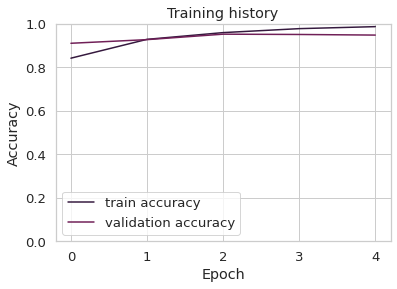

In [36]:
plt.plot(history_cpu_train_acc, label='train accuracy')
plt.plot(history_cpu_val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

The training accuracy starts to approach 90% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

### Load Pretrained Model

In [37]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

### Model Evaluation

In [38]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.9192200557103064

The accuracy is very low on the test set. Our model needs tuning.

lets check the prediction, we'll define a helper function to get the predictions from our model.

In [39]:
def get_predictions(model, data_loader):
  # put model in evaluation mode
  model = model.eval()
  # Create empty lists to store outputs
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for batch in data_loader:
      # We'll move the example batch of our test data to the GPU
      texts = batch["review_text"]
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["targets"].to(device)
      # Perform a forward pass. This will return logits.
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      # Get the predictions
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities.

In [40]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report.

In [41]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.91      0.92      0.91       213
     neutral       0.93      0.89      0.91       209
    positive       0.92      0.94      0.93       296

    accuracy                           0.92       718
   macro avg       0.92      0.92      0.92       718
weighted avg       0.92      0.92      0.92       718



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix-

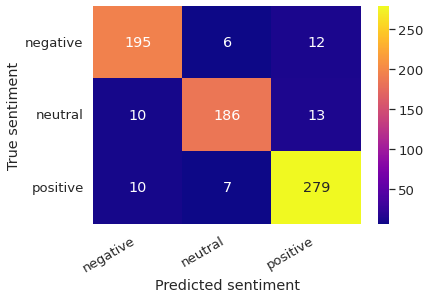

In [42]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="plasma")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews.

That's a good overview of the performance of our model. But let's have a look at an example from our test data.

In [43]:
idx = 29
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

from textwrap import wrap 
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

malas download

True sentiment: negative


Now, we can look at the confidence of each sentiment of our mode.

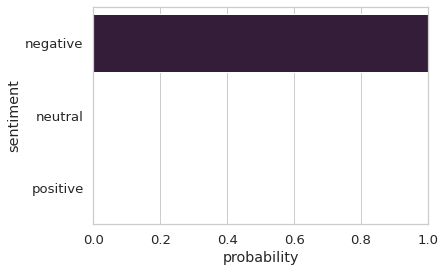

In [44]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])
plt.show()

### Prediction on Raw Text

In [45]:
# Let's use our model to predict the sentiment of some raw text
raw_text = "aplikasi ini sangat bagus"


In [46]:
def prediction_on_raw_data(raw_text):
  encoded_review = tokenizer.encode_plus(
  raw_text,
  padding='max_length', # Pad sentence to max length
  truncation=True,  #Truncate sentence to max length
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  return_attention_mask=True, # Return attention mask
  return_tensors='pt',  # Return torch objects
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)

  _, prediction = torch.max(output, dim=1)
  
  print(f'Review text: {raw_text}')
  print(f'Sentiment  : {class_names[prediction]}')



In [47]:
prediction_on_raw_data(raw_text)

Review text: aplikasi ini sangat bagus
Sentiment  : positive


In [48]:
raw_text = "game ini banyak bugnya jelek"
prediction_on_raw_data(raw_text)


Review text: game ini banyak bugnya jelek
Sentiment  : negative


In [49]:
raw_text = "tolong perbaiki banyak bug"
prediction_on_raw_data(raw_text)

Review text: tolong perbaiki banyak bug
Sentiment  : neutral
